In [1]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

# import mvts_utils as utils
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "10"

In [3]:
from utils import (
    adf_test,
    kpss_test,
    grangers_causation_matrix,
    adjust,
    cointegration_test,
    splitter,
    create_plot,
    forecast_accuracy
)

### Loading the Dataset

In [4]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin_19_22.csv",index_col='date',parse_dates=['date'])

In [5]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [6]:
model ='CRYPTOBERT'
df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [7]:
ts_prices_btc= ts_prices_btc.join(df)

In [8]:
# Extracting some features from VADER sentiment time series
model ='VADER'
df_ = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])
ts_prices_btc= ts_prices_btc.join(df_[['total_stopwords','average_word_length']])

In [9]:
# Remove Neutral Time Series
for c in ts_prices_btc.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column neutral_count


In [10]:
ts_prices_btc = ts_prices_btc[ts_prices_btc.index.year == 2022]
ts_prices_btc.index.year.unique()

Index([2022], dtype='int32', name='date')

In [11]:
ts_prices_btc.head(5)

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2022-01-01,46319.65,27,4,71,7628,7782,3018,5.443135
2022-01-02,47816.08,32,2,70,8501,3738,3226,5.627238
2022-01-03,47387.21,48,4,96,11417,5290,4498,5.619037
2022-01-04,46531.14,26,3,83,9083,4849,3502,5.606973
2022-01-05,45938.02,39,5,110,10862,6430,4382,5.487421


In [12]:
df = ts_prices_btc

In [13]:
df.isna().sum()

price                  0
positive_count         0
negative_count         0
total_posts            0
total_words            0
total_comments         0
total_stopwords        0
average_word_length    0
dtype: int64

In [14]:
# Checking for Stationarity
for i in range(0,len(df.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df.iloc[:,i])
    kpss_test(df.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series is stati

Since some of the time series are not stationary, we'll have to take first difference

In [15]:
df_first_differenced = df.diff().dropna()
# Checking for Stationarity
for i in range(0,len(df_first_differenced.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df_first_differenced.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df_first_differenced.iloc[:,i])
    kpss_test(df_first_differenced.iloc[:,i])
    print("*"*100)


Series: price
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test


### VAR Model with only 2022 data

In [16]:
df.columns

Index(['price', 'positive_count', 'negative_count', 'total_posts',
       'total_words', 'total_comments', 'total_stopwords',
       'average_word_length'],
      dtype='object')

In [17]:
df_first_differenced.head(2)

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2022-01-02,1496.43,5.0,-2.0,-1.0,873.0,-4044.0,208.0,0.184102
2022-01-03,-428.87,16.0,2.0,26.0,2916.0,1552.0,1272.0,-0.008201


In [18]:
gc_res = grangers_causation_matrix(df_first_differenced, variables = df_first_differenced.columns, maxlag=40)    

In [19]:
def negative_grey(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_grey).applymap(negative_bold)

,price_x,positive_count_x,negative_count_x,total_posts_x,total_words_x,total_comments_x,total_stopwords_x,average_word_length_x
price_y,1.000000,0.057500,0.008400,0.008800,0.157100,0.057000,0.231400,0.408400
positive_count_y,0.000100,1.000000,0.000000,0.000100,0.011200,0.015400,0.010700,0.033500
negative_count_y,0.031100,0.000100,1.000000,0.000000,0.031000,0.000300,0.063100,0.004900
total_posts_y,0.002300,0.000000,0.001600,1.000000,0.164000,0.008800,0.332400,0.120900
total_words_y,0.000000,0.000000,0.000600,0.000000,1.000000,0.000100,0.251700,0.000100
total_comments_y,0.000000,0.082200,0.014900,0.032300,0.012000,1.000000,0.005500,0.070500
total_stopwords_y,0.000000,0.000000,0.000500,0.000000,0.527100,0.000100,1.000000,0.000200
average_word_length_y,0.005800,0.024800,0.198700,0.002600,0.006900,0.003700,0.010100,1.000000


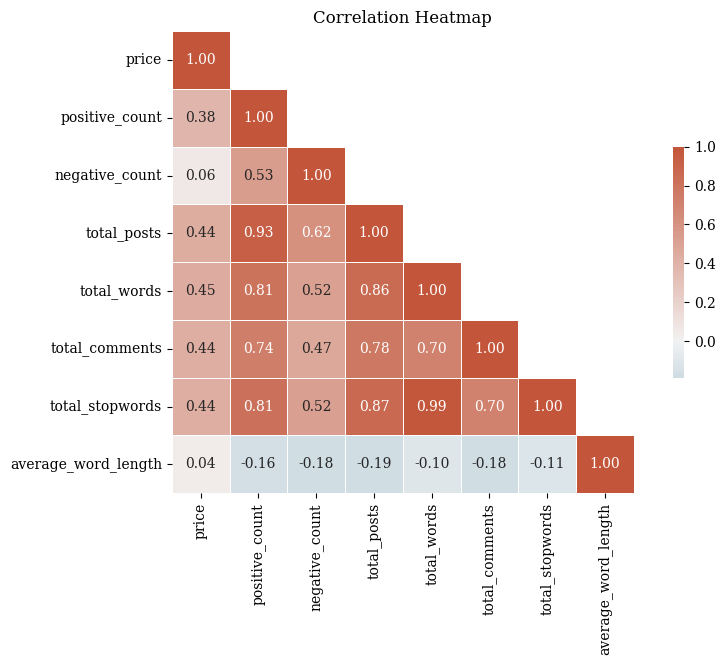

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Heatmap')

# Show the heatmap
plt.show()

In [21]:
df_first_differenced = df_first_differenced[['price','positive_count', 'total_posts',
       'total_words','total_comments']]

In [22]:
cointegration_test(df_first_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  633.38    > 60.0627   =>   True
positive_count                 ::  460.49    > 40.1749   =>   True
total_posts                    ::  306.35    > 24.2761   =>   True
total_words                    ::  169.63    > 12.3212   =>   True
total_comments                 ::  60.57     > 4.1296    =>   True


In [23]:
train_df, test_df = splitter(df_first_differenced)
nobs = len(test_df)

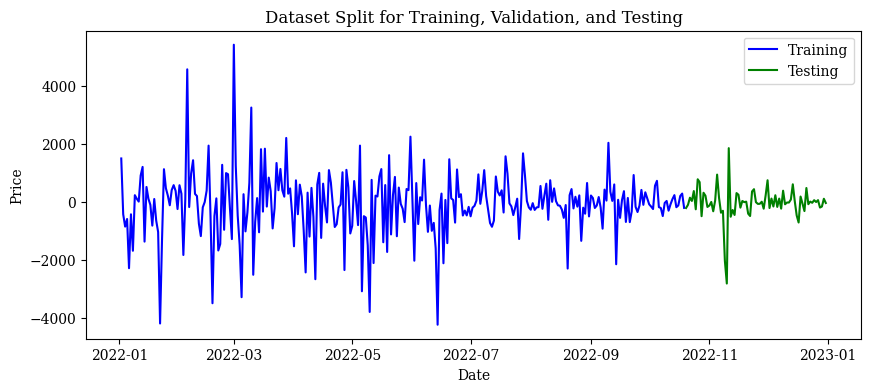

In [24]:
plt.figure(figsize=(10, 4))

plt.plot(train_df.index, train_df['price'], label='Training', color='blue')
# plt.plot(df_for_validation.index, df_for_validation['price'], label='Validation', color='orange')
plt.plot(test_df.index, test_df['price'], label='Testing', color='green')

# Add title and labels
plt.title('Dataset Split for Training, Validation, and Testing')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show plot
plt.show()

In [25]:
train_df.index[0],train_df.index[-1], len(train_df)

(Timestamp('2022-01-02 00:00:00'), Timestamp('2022-10-19 00:00:00'), 291)

In [26]:
test_df.index[0],test_df.index[-1],len(test_df)

(Timestamp('2022-10-20 00:00:00'), Timestamp('2022-12-31 00:00:00'), 73)

In [27]:
model = VAR(train_df)
x = model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,51.10,51.17,1.559e+22,51.13
1,50.20,50.61*,6.343e+21,50.37
2,49.90,50.65,4.675e+21,50.20
3,49.72,50.81,3.924e+21,50.16
4,49.56,50.99,3.345e+21,50.14*
5,49.56*,51.33,3.341e+21*,50.27
6,49.56,51.68,3.369e+21,50.41
7,49.65,52.11,3.697e+21,50.64
8,49.70,52.50,3.901e+21,50.83
9,49.78,52.92,4.251e+21,51.05


In [28]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2024
Time:                     13:56:46
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    51.5776
Nobs:                     286.000    HQIC:                   50.5819
Log likelihood:          -9037.04    FPE:                4.77810e+21
AIC:                      49.9158    Det(Omega_mle):     3.09252e+21
--------------------------------------------------------------------
Results for equation price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                  -107.859252        67.823360           -1.590           0.112
L1.price                 -0.032799         0.062156           -0.528           0.598
L1.positive_count        11.997258        16

In [29]:
irf = model_fitted.irf(periods=8)

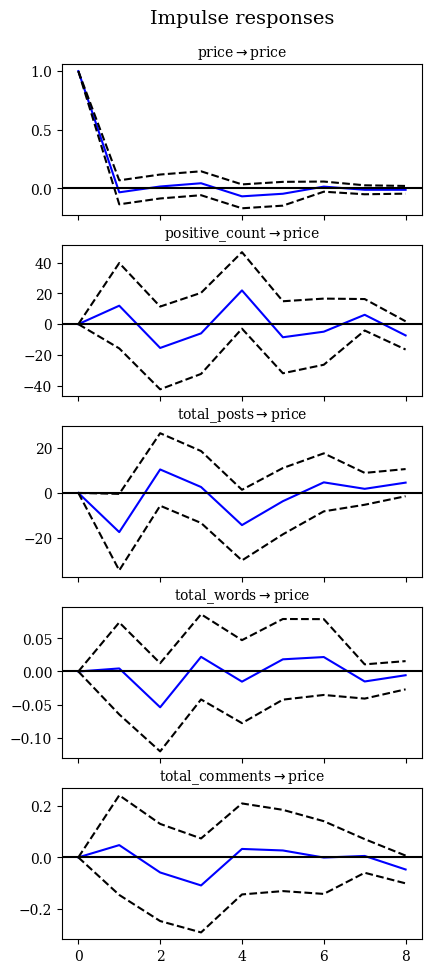

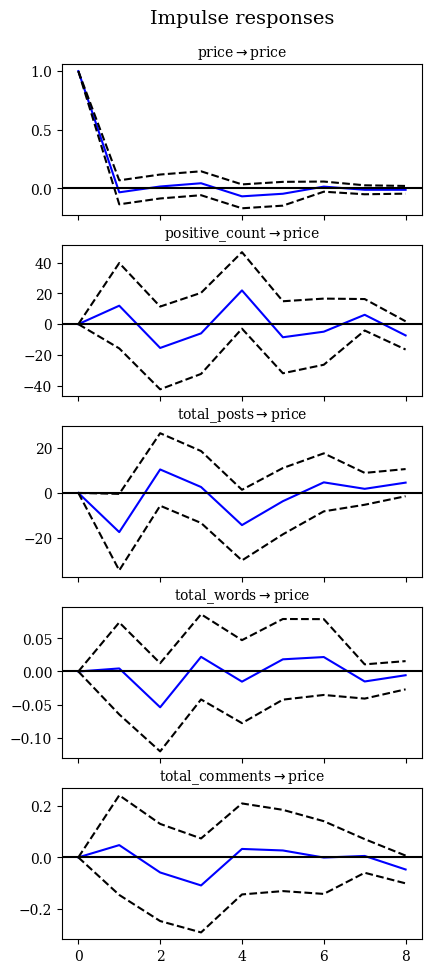

In [30]:
irf.plot(orth=False, 
        response='price',
        signif=0.10,
        figsize=(4, 10),
        subplot_params={'fontsize': 10})

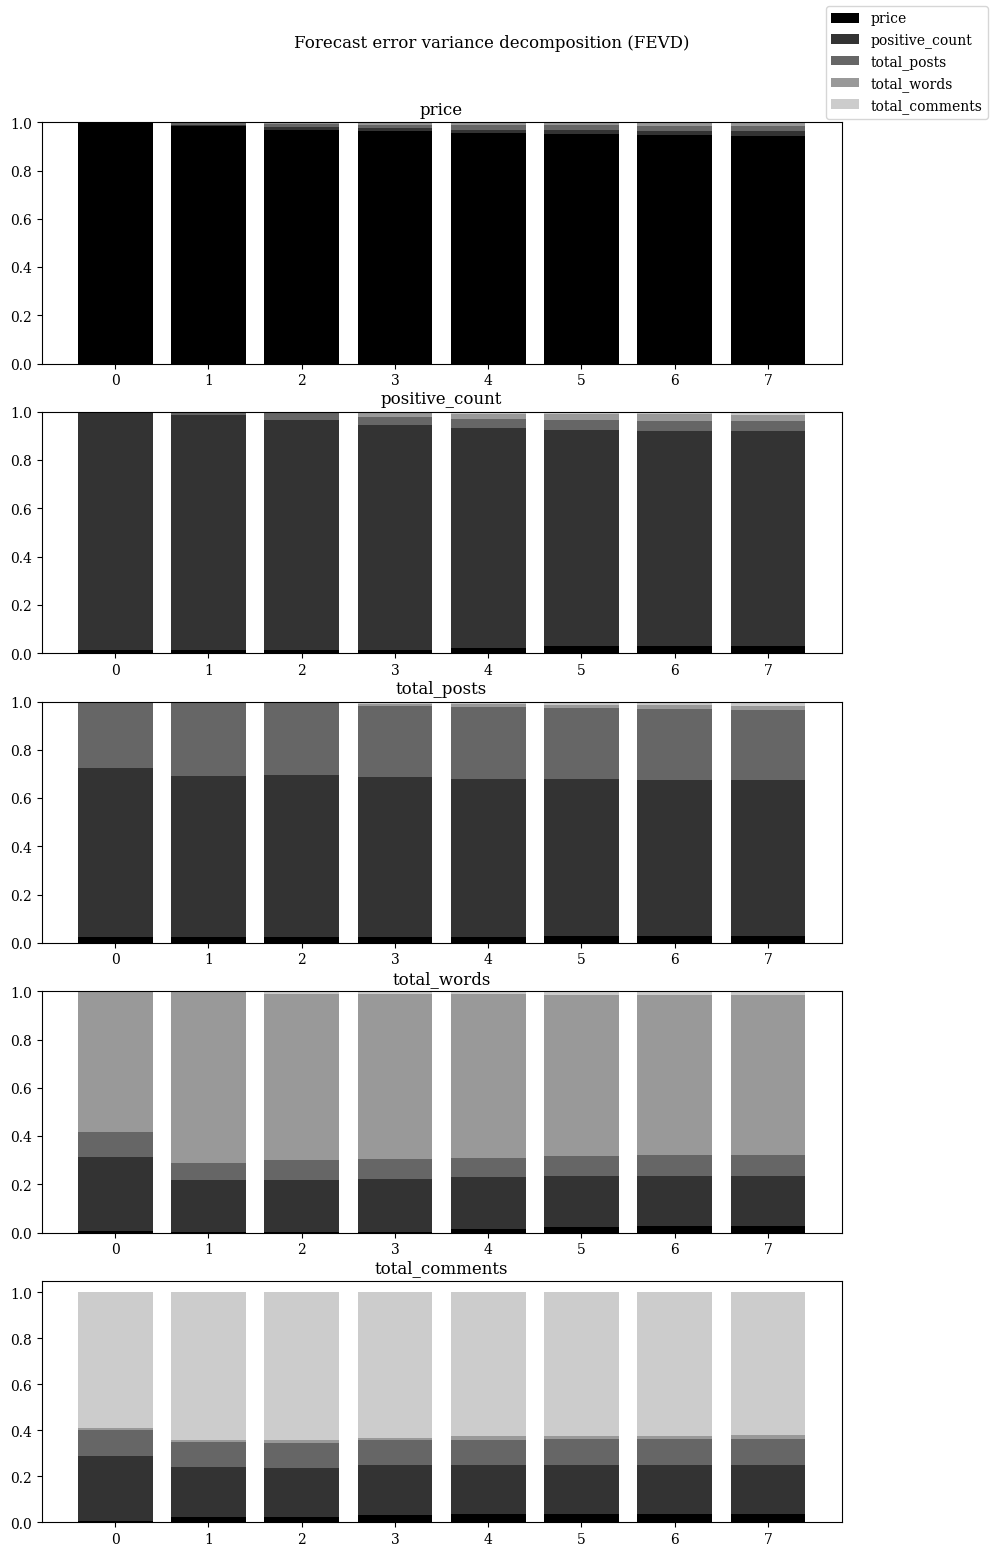

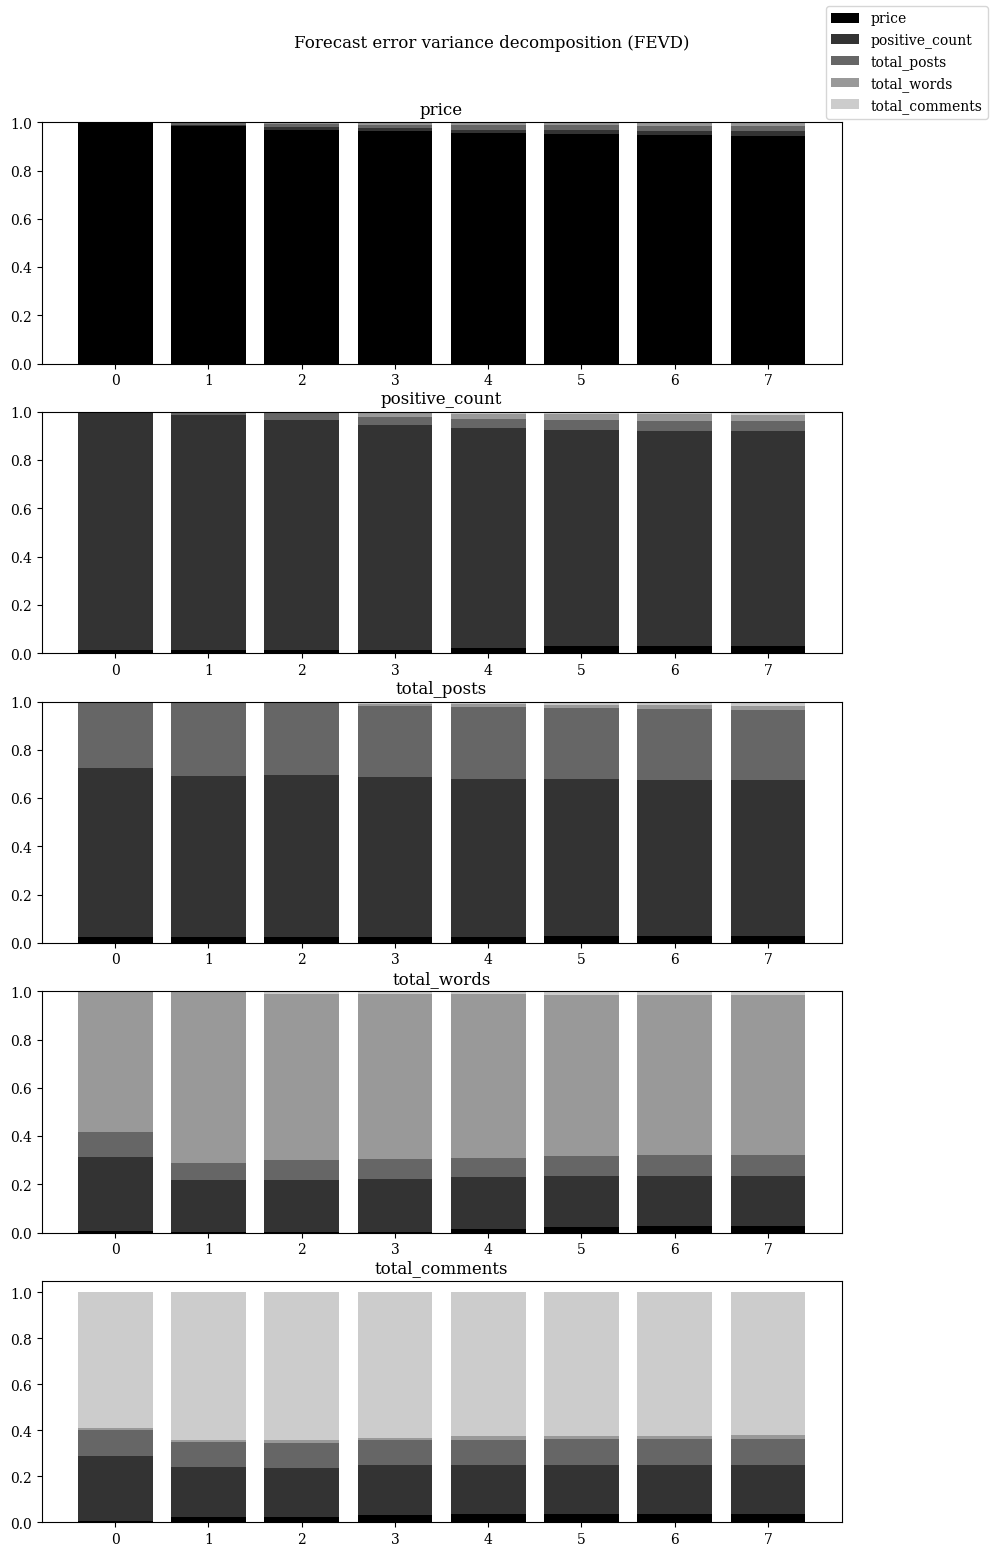

In [31]:
fevd = model_fitted.fevd(8)
fevd.plot(figsize=(10, 16))
# plt.xticks(fontsize=5)
# plt.yticks(fontsize=5)
# plt.show()

In [32]:
# Input data for forecasting
lag_order=model_fitted.k_ar
forecast_input = train_df.values[-lag_order:]
forecast_input

array([[-1.8583e+02, -1.0000e+00,  2.0000e+00, -1.7290e+03,  1.2300e+02],
       [-1.2533e+02, -5.0000e+00,  1.0000e+00,  1.8420e+03, -1.9000e+01],
       [ 2.0014e+02,  9.0000e+00,  2.0000e+01,  4.8110e+03,  4.5000e+02],
       [ 2.8498e+02, -1.0000e+00, -1.3000e+01, -5.4250e+03, -3.2700e+02],
       [-2.0987e+02, -4.0000e+00, -2.0000e+00,  2.0000e+01,  3.9000e+02]])

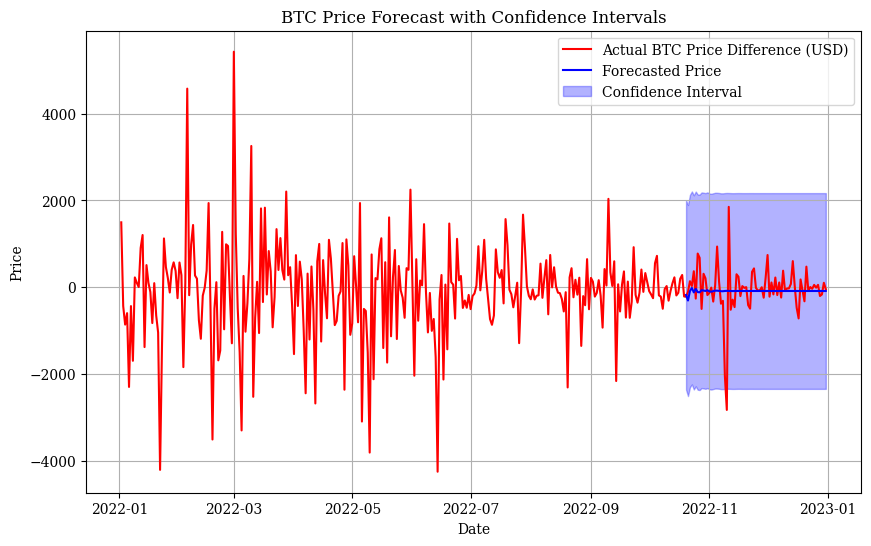

In [33]:
forecast_steps = 73
forecast_result = model_fitted.forecast_interval(forecast_input, steps=forecast_steps)

# Extract the forecast and confidence intervals
forecast_values = forecast_result[0]
lower_bound = forecast_result[1]
upper_bound = forecast_result[2]

# Extract the 'price' variable forecast
price_forecast = forecast_values[:, 0]
price_lower = lower_bound[:, 0]
price_upper = upper_bound[:, 0]

# Create a date range for the forecast
# forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, closed='right')

# # Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_first_differenced.index, df_first_differenced['price'], label='Actual BTC Price Difference (USD)',color='red')
plt.plot(test_df.index, price_forecast, label='Forecasted Price', color='blue')
plt.fill_between(test_df.index, price_lower, price_upper, color='blue', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Forecast with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

In [34]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_first_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.01
positive_count : 2.03
total_posts : 2.08
total_words : 2.03
total_comments : 2.0


In [35]:
# df = ts_prices_btc[['price','CRYPTOBERT_submission_Negative','CRYPTOBERT_submission_Positive','total_submission','CRYPTOBERT_comment_Negative','CRYPTOBERT_comment_Positive','total_comment']]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [36]:
forecast = pd.DataFrame(model_fitted.forecast(y= forecast_input, steps=nobs), index = test_df.index,columns = test_df.columns)

In [37]:
forecast.iloc[0]

price            -174.676649
positive_count     -0.576468
total_posts        -4.689624
total_words       953.419922
total_comments   -378.667152
Name: 2022-10-20 00:00:00, dtype: float64

In [38]:
df_first_differenced.iloc[290]

price            -209.87
positive_count     -4.00
total_posts        -2.00
total_words        20.00
total_comments    390.00
Name: 2022-10-19 00:00:00, dtype: float64

In [39]:
df_first_differenced.columns

Index(['price', 'positive_count', 'total_posts', 'total_words',
       'total_comments'],
      dtype='object')

In [40]:
row = df.iloc[[0]][['price','positive_count',  'total_posts', 'total_words',
       'total_comments']]
row

,price,positive_count,total_posts,total_words,total_comments
date,,,,,
2022-01-01,46319.65,27,71,7628,7782


In [41]:
# Invert Transformation
df_result = pd.concat([df_first_differenced.iloc[:291],forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

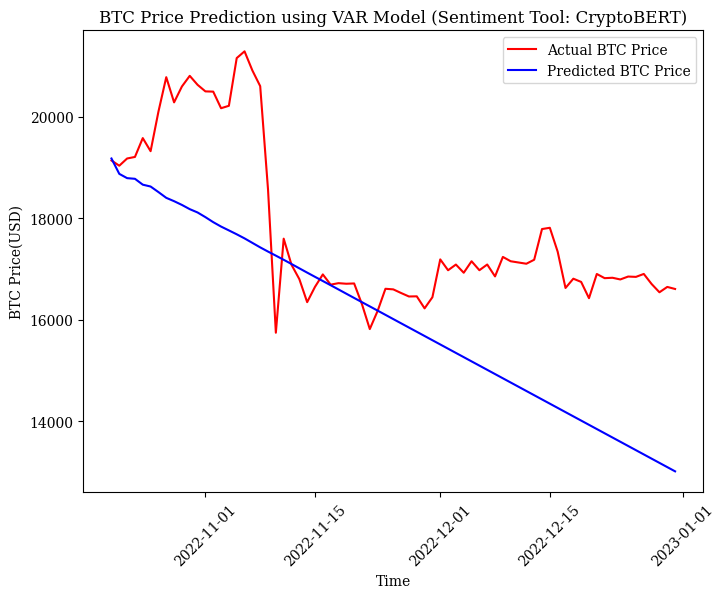

In [42]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(ts_prices_btc['price'].iloc[-nobs:], color = 'red', label = 'Actual BTC Price')
plt.plot(df_result['price'].iloc[-nobs:], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction using VAR Model (Sentiment Tool: CryptoBERT)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('BTC Price(USD)')
plt.legend()
plt.show()

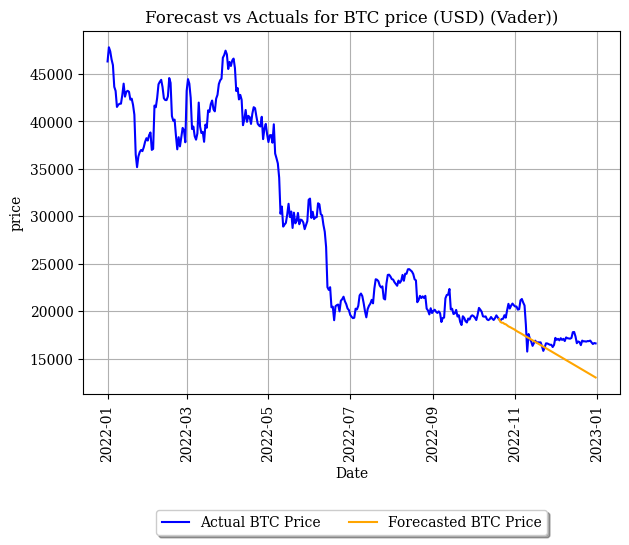

In [43]:
data_predicted = df_result['price'][-nobs:]
data_actual = df['price']
create_plot(data_predicted, data_actual, 'BTC', 'Vader')

In [44]:
print('Forecast Accuracy of: BTC Price')
# accuracy_prod = 
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:],['BTC_ModelB'])
res

Forecast Accuracy of: BTC Price


,MAE,MAPE,MSE,RMSE
BTC_ModelB,1824.390662,10.215622,4.806688e+06,2192.416035
